<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-Forward Networks for Natural Language Processing

The need for more complex architectures comes from the perceptron being unable to learn nontrivial patterns, i.e. patterns that are not *linearly separable*.

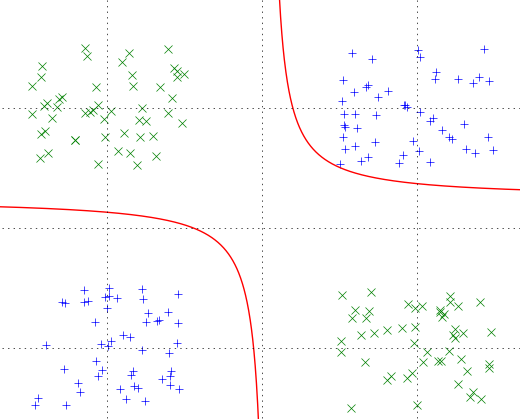

A family of neural networks called *feed-forward networks* are much more adept at learning these patterns. Two of these networks are:

*   multilayer perceptron (MLP)
*   convolutional neural network (CNN)

The MLP extends the perceptron by grouping multiple perceptrons together in a single layer and stacking multiple layers together.

CNNs are inspired by window filters used in signal processing. The use of window filters allows CNNs to learn localized patterns in their inputs. This has lead to them being a standard choice for computer vision tasks, as well as being capable of detecting substructures in sequential data (i.e. words and sentences). 


## The Multilayer Perceptron

MLPs group multiple perceptrons in a single layer, where the output is a vector instead of a single value. An additional aspect of the MLP is between each layer is a nonlinearity (such as the ReLU).

The simplest MLP is composed of three stages of representations and two `Linear` layers. The structure goes as follows:

* **input vector** (representation) - this is the vector given to the model, such as the one-hot representation of the Yelp reviews
* **first `Linear` layer**
* **hidden vector** (representation) - computed by the first `Linear` layer using the input vector
* **second `Linear` layer**
* **output vector** (representation) - computed by the second `Linear` layer using the hidden vector

The power of the MLP comes from the additional `Linear` layer, allowing the model to learn intermediate representations that are *linearly separable*.



### A Simple Example: XOR




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

### Global Settings

In [2]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

### Defining the Model

In [3]:
class MultilayerPerceptron(nn.Module):
    """
    """
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.

        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

### Generate Toy Data

In [4]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
        
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

### Visualize Results

In [5]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

### Initial Data Plot

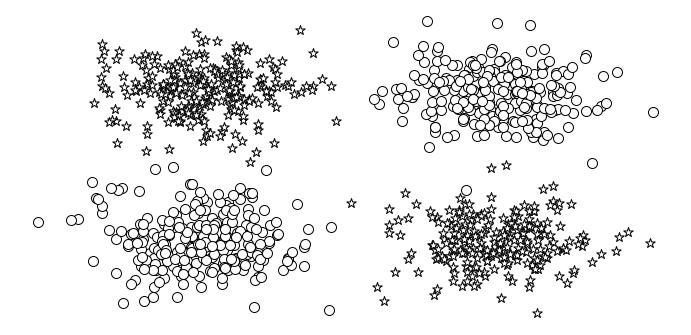

In [6]:
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

As shown above, the toy data cannot be separated by a line, which proves very difficult for a perceptron model to learn.

### Training a Perceptron

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


(-6.505291938781738, 6.362272262573242, -5.896823883056641, 5.761417865753174)

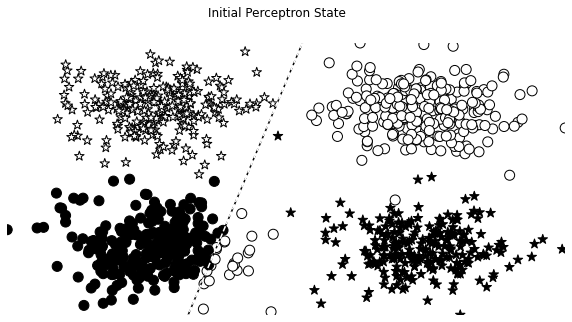

In [7]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # isn't ever used but we still set it


seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')

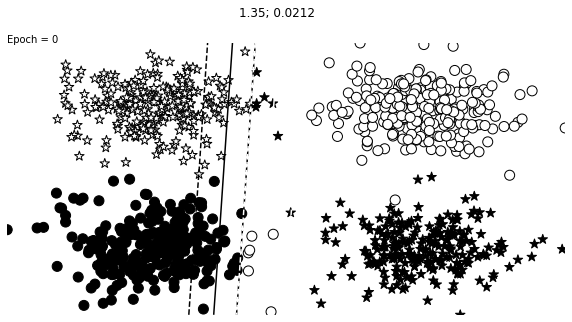

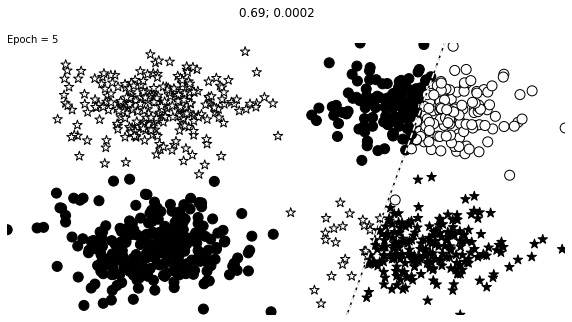

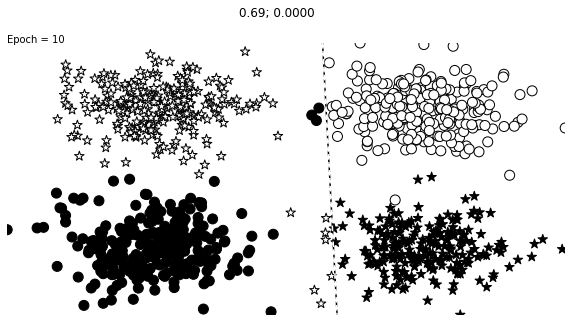

In [8]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp1.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    
    if epoch % 5 == 0:
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                          title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1

### Training a 2-layer MLP

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


(-6.326869964599609, 6.49187707901001, -6.096979141235352, 5.488681316375732)

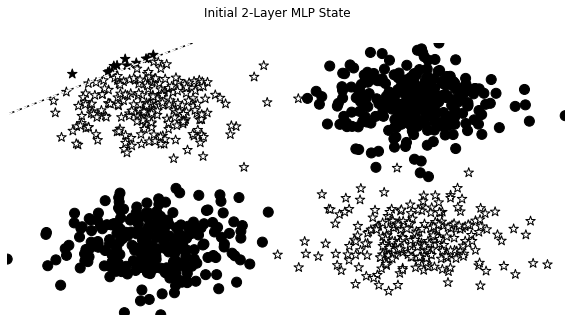

In [9]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.


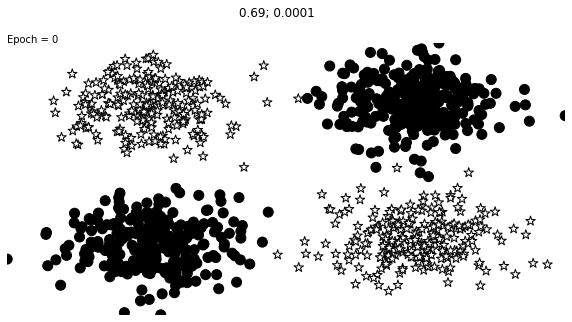

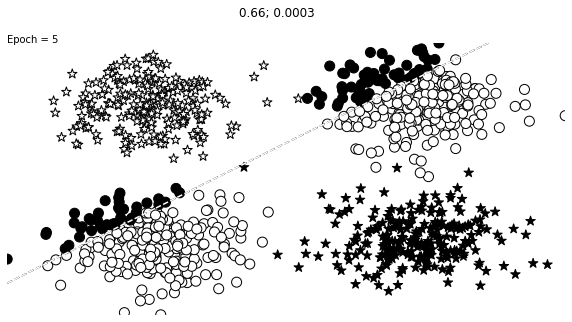

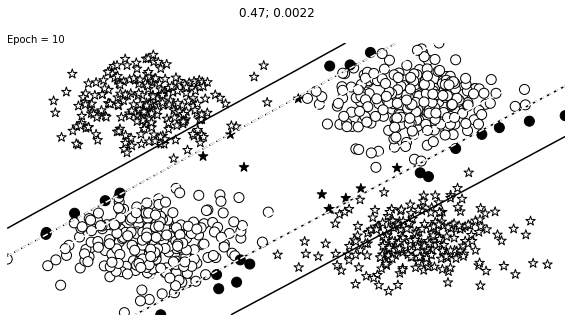

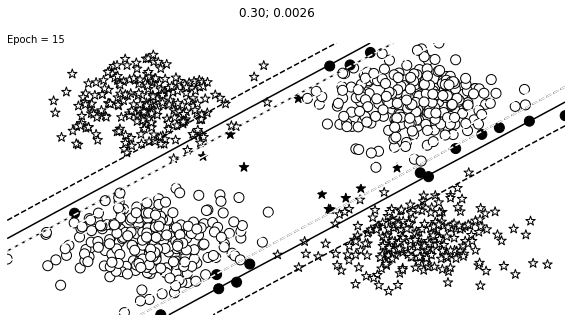

In [10]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp2.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    if epoch % 5 == 0:            
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                          title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1

### Inspecting the representations

In [13]:
batch_size = 100

In [14]:
def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ['black', 'white'] 
    markers = ['o', '*'] 

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices,0], x_data[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(activations[data_indices,0], activations[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

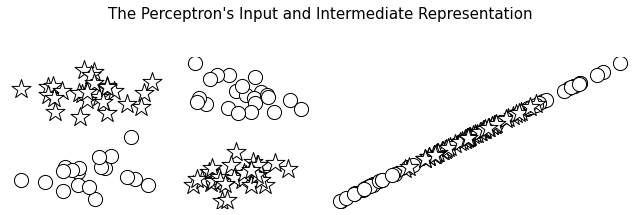

In [15]:
plot_intermediate_representations(mlp1, 
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))

The plot above demonstrates how the perceptron does not have the flexibility to change the data inputs to a representation that is linearly separable.

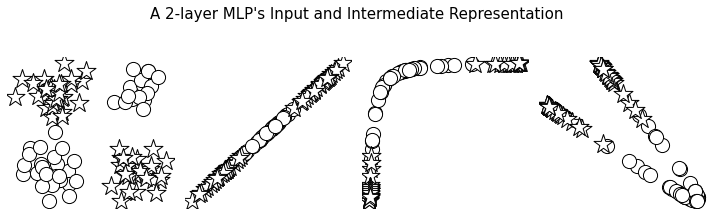

In [16]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))

This plot shows how just a two layer MLP is able to "warp" the data inputs until it gets a representation that is linearly separable (the right most data plot).

### Implementing MLP's in PyTorch

A simple MLP can be instantiated with PyTorch using two `Linear` modules. It is a common convention to name each linear layer `fc1`, `fc2`, etc. This is short for "fully connected layer". Due to the sequential nature of the layers, it is important to ensure the number of outputs from the first layer match the number of inputs to the second layer. Additionally, there is a ReLU nonlinearity applied to the output of the first linear layer. Without this nonlinearity, stacking two linear layers is equivalent to one linear layer, and is therefore unable to learn more complex patterns within the data.

*Example 4-1. Multilayer perceptron using PyTorch*



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [19]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. 
                tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(intermediate)
        
        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

*Example 4-2. An example instantiation of an MLP*


In [20]:
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Instantiate model
mlp = MultilayerPerceptron(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


It is good practice to test the "wiring" of the model by passing some random inputs before moving to model training. This allows for some simple sanity checks and debugging. 

*Example 4-3. Testing the MLP with random inputs*


In [21]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("values: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
values: 
tensor([[0.8329, 0.4277, 0.4363],
        [0.9686, 0.6316, 0.8494]])


*Example 4-4. Producing probabilistic outputs with a multilayer perceptron classifier (notice the `apply_softmax = True` option*


In [22]:
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
values: 
tensor([[0.2087, 0.2868, 0.3127, 0.1919],
        [0.1832, 0.2824, 0.3649, 0.1696]], grad_fn=<SoftmaxBackward>)


In this example, the MLP outputs a tensor that has two rows and four columns. The rows correspond to the batch dimension, which is the number of data points in the minibatch. The columns are the final features for each data point. In a classification setting, these features correspond to a probability distribution. 

## Example: Surname Classification with an MLP

This example applies the MLP to the task of classifying surnames to their country of origin. Inferring a user's demographics can be useful for product recommendations or ensuring fair outcomes across different demographics. It should be noted that identifying attributes such as demographic information are "protected attributes" and much care and consideration should be exercised when using these attributes. 

### The Surnames Dataset

This dataset is a collection of 10,000 surnames from 18 different nationalities. 

Some interesting properties of the dataset:

* it is imbalanced: the top three classes represent more than 60% of the data
  * 27% are English
  * 21% are Russian
  * 14% are Arabic
* the 15 remaining nationalities have a decreasing frequency (a common trait of languages)
* there is a strong relationship between nationality of origin and surname spelling 

To create the final dataset, the original dataset went through some preprocessing. First, the original dataset was more than 70% Russian. To reduce the imbalance, a random subset of the Russian surnames were sampled. Next, the dataset was grouped by nationality and split into: 70% train, 15% validation, 15% test such that the distribution of nationality labels were approximately the same for all splits.

Implementing the `SurnameDataset` is nearly identical to the implementation of the `ReviewDataset`, with the exception in how the `__getitem()__` method is defined. Instead of returning a vectorized review, `__getitem()__` returns a vectorized surname and the index corresponding to the surname's nationality.

*Example 4-5. Implementing `SurnameDataset.__getitem__()`*

```
class SurnameDataset(Dataset):
    # Implementation is nearly identical to Example 3-14

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        surname_vector = \
            self._vectorizer.vectorize(row.surname)
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}
```

### Vocabulary, Vectorizer, and DataLoader

#### The Vocabulary class

As before the `Vocabulary` handles the coordination of mapping tokens to integers, and the inverse mapping of integers to tokens using two dictionaries. Additionally, it uses the following methods:

* `add_token()` - add new tokens into the vocab
* `lookup_token()` - retrieve the index corresponding to a token
* `lookup_index()` - retrieve the token corresponding to an index

In contrast to the Yelp reviews `Vocabulary`, one-hot representations are used and frequencies of characters are not counted. Recall the frequencies were used to restrict only the most frequent tokens above a given threshold. The rationale is the dataset is small and most characters are frequent enough.

#### The SurnameVectorizer

The `SurnameVectorizer` is responsible for applying the `Vocabulary` and converting the surname into a vector. Unlike the review vectorizer, the string is not split on whitespace. From this token splitting a collapsed one-hot vector is created, ignoring any sequence information. Another difference is the `UNK` token is now represented with the `"@"` symbol.

*Example 4-6. Implementing `SurnameVectorizer`*

```
class SurnameVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """Vectorize the provided surname

        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)
```

### The SurnameClassifier Model

*Example 4-7. The `SurnameClassifier` using an MLP*

```
class SurnameClassifier(nn.Module):
    """A 2-layer MLP for classifying surnames"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be False if used with the cross-entropy losses
        Returns:
            the resulting tensor.
                tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector
```

### The Training Routine

*Example 4-8. Hyperparameters and program options for the MLP-based Yelp review classifier*

```
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyperparameters
    hidden_dim=300,
    # Training hyperparameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options omitted
    )
```

*Example 4-9. Instantiating the dataset, model, loss, and optimizer*

```
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                               hidden_dim=args.hidden_dim,
                               output_dim=len(vectorizer.nationality_vocab))

classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
```

#### The training loop

*Example 4-10. A snippet of the training loop*

```
```

### Model Evaluation and Prediction

#### Evaluating on the test dataset

#### Classifying a new surname

*Example 4-11. Inference using an existing model (classifier): Predicting the nationaility given a name*

```
```

#### Retrieving the top k predictions for a new surname

*Example 4-12. Predicting the top-k nationalities*

```
```

## Regularizing MLPs: Weight Regularization and Structural Regularization (or Dropout)

*Example 4-13. MLP with dropout*

```
```

## Convolutional Neural Networks

### CNN Hyperparameters

#### Dimension of the convolution operation

#### Channels

#### Kernel size

#### Stride

#### Padding

#### Dialation

### Implementing CNNs in PyTorch

*Example 4-14. Artificial data and using a `Conv1d` class*


*Example 4-15. The iterative application of convolutions to data*

*Example 4-16*

## Example: Classifying Surnames by Using a CNN

### The SurnameDataset Class

*Example 4-17. `SurnameDataset` modified for passing the maximum surname length*

```
```

### Vocabulary, Vectorizer, and DataLoader

*Example 4-18. Implementing the `SurnameVectorizer` for CNNs*

```
```

### Reimplementing the SurnameClassifier with Convolutional Networks

*Example 4-19. The CNN-based `SurnameClassifier`*

```
```

### The Training Routine

*Example 4-20. Input arguments to the CNN surname classifier*

```
```

### Model Evaluation and Prediction

#### Evaluating on the test dataset

#### Classifying or retrieving top predictions for a new surname

*Example 4-21. Using the trained model to make predictions*

```
```

## Miscellaneous Topics in CNNs

### Pooling

### Batch Normalization (BatchNorm)

*Example 4-22. Using a Conv1D layer with batch normalization*

```
```

### Network-in-Network Connections (1x1 Convolutions)

### Residual Connections/Residual Block